In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV,LogisticRegressionCV, RidgeClassifierCV
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS

In [197]:
# import data
data = pd.read_csv('./data/final_data.csv', index_col=[0])


In [198]:
print(data.shape)
data.head()


(570, 12)


,title_fix,Company,Link,Description,location,work_type,experience,sal_freq,min_sal,max_sal,avg_sal,sal_cat
0,Data Scientist,Algorithmic Trading Strategies Pty Ltd,https://au.indeed.com/company/Algorithmic-Trad...,We are looking for an experienced Data Scienti...,Sydney,Full Time,Senior,year,160000.0,180000.0,170000.0,LDS
1,Data Scientist,Accenture,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Are you curious about how digital is changing ...,Sydney,Full Time,Mid,year,110000.0,150000.0,130000.0,LDS
2,Data Scientist,Quantexa,https://au.indeed.com/rc/clk?jk=43597fa4327016...,We are looking for individuals with a proven t...,Sydney,Full Time,Mid,year,71000.0,94000.0,82500.0,LDS
3,Data Scientist,Freelancer.com,https://au.indeed.com/rc/clk?jk=56398451dd58fd...,Eleven-time Webby award-winning Freelancer.com...,Sydney,Full Time,Mid,year,70000.0,110000.0,90000.0,LDS
4,Data Scientist,Correlate Resources,https://au.indeed.com/rc/clk?jk=ddc0aa1d153a01...,Our client is an Australian market leader in t...,Sydney,Contract,Junior,day,156000.0,156000.0,156000.0,LDS


In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 0 to 569
Data columns (total 12 columns):
title_fix      570 non-null object
Company        570 non-null object
Link           570 non-null object
Description    570 non-null object
location       570 non-null object
work_type      570 non-null object
experience     570 non-null object
sal_freq       570 non-null object
min_sal        158 non-null float64
max_sal        158 non-null float64
avg_sal        570 non-null float64
sal_cat        570 non-null object
dtypes: float64(3), object(9)
memory usage: 57.9+ KB


In [200]:
# dropping unneeded columns
data.drop(['max_sal', 'min_sal','Link','Company'], axis=1, inplace=True)

In [201]:
data.head()

,title_fix,Description,location,work_type,experience,sal_freq,avg_sal,sal_cat
0,Data Scientist,We are looking for an experienced Data Scienti...,Sydney,Full Time,Senior,year,170000.0,LDS
1,Data Scientist,Are you curious about how digital is changing ...,Sydney,Full Time,Mid,year,130000.0,LDS
2,Data Scientist,We are looking for individuals with a proven t...,Sydney,Full Time,Mid,year,82500.0,LDS
3,Data Scientist,Eleven-time Webby award-winning Freelancer.com...,Sydney,Full Time,Mid,year,90000.0,LDS
4,Data Scientist,Our client is an Australian market leader in t...,Sydney,Contract,Junior,day,156000.0,LDS


### Dummify


In [203]:
# dummify columns
loc_dum = pd.get_dummies(data['location'])
work_dum = pd.get_dummies(data['work_type'])
exp_dum = pd.get_dummies(data['experience'])
sal_dum = pd.get_dummies(data['sal_freq'])
title_dum = pd.get_dummies(data['title_fix'])

In [204]:
# concat dummy columns with description( to be vectorized) and future taget columns
dummied_data= pd.concat([data[['title_fix','sal_cat','Description']], loc_dum, work_dum, 
                         exp_dum, sal_dum,title_dum],axis=1)

In [205]:
dummied_data.head()

,title_fix,sal_cat,Description,Location Unknown,Melbourne,Sydney,Contract,Full Time,Work Type Unknown,Junior,...,Salary Frequency Unknown,day,hour,week,year,Business Analyst,Business Intelligence,Data Analyst,Data Engineer,Data Scientist
0,Data Scientist,LDS,We are looking for an experienced Data Scienti...,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,Data Scientist,LDS,Are you curious about how digital is changing ...,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,Data Scientist,LDS,We are looking for individuals with a proven t...,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,Data Scientist,LDS,Eleven-time Webby award-winning Freelancer.com...,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,Data Scientist,LDS,Our client is an Australian market leader in t...,0,0,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


# What features best determine Salary?

In [206]:
# X and Y data
X = dummied_data.iloc[:,3:]
y = dummied_data.iloc[:,1]


In [207]:
print(X.shape)
X.head()

(570, 19)


,Location Unknown,Melbourne,Sydney,Contract,Full Time,Work Type Unknown,Junior,Mid,Senior,Salary Frequency Unknown,day,hour,week,year,Business Analyst,Business Intelligence,Data Analyst,Data Engineer,Data Scientist
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [208]:
# Train/Test data Categorisation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [209]:
y.value_counts()

LDA    212
LDS    117
LBI     88
LBA     44
LDE     41
HDA     29
HBI     18
HDS     14
HBA      7
Name: sal_cat, dtype: int64

In [210]:
def modeller(model):
    print(model)
    clf = model.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('___'*10 + 'Accuracy Score' +'___'*10)
    print()
    print(accuracy_score(y_test,y_pred))
    print()
    print('___'*10 + 'Confusion Matrix' +'___'*10)
    print()
    print(confusion_matrix(y_test,y_pred))
    print()
    print()
    print('___'*10 + 'Classidication Report' +'___'*10)
    print()
    print(classification_report(y_test,y_pred))

In [211]:
modeller(DecisionTreeClassifier(random_state=0))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
______________________________Accuracy Score______________________________

0.8412698412698413

______________________________Confusion Matrix______________________________

[[ 2  0  0  0  1  0  0  0  0]
 [ 0  3  0  0  0  3  0  0  0]
 [ 0  0  4  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  3]
 [ 0  0  0  0 14  0  0  0  0]
 [ 0  7  0  0  0 23  0  0  0]
 [ 0  0  2  0  0  0 67  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  7  0  0  0  0 31]]


______________________________Classidication Report______________________________

              precision    recall  f1-score   support

         HBA       1.00      0.67      0.80         3
         HBI  

In [212]:
modeller(LinearSVC(multi_class='ovr'))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
______________________________Accuracy Score______________________________

0.8571428571428571

______________________________Confusion Matrix______________________________

[[ 2  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  4  0  0  0]
 [ 0  0  4  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0 14  0  0  0  0]
 [ 0  2  0  0  0 28  0  0  0]
 [ 0  0  1  0  0  0 68  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  7  0  0  0  0 31]]


______________________________Classidication Report______________________________

              precision    recall  f1-score   support

         HBA       1.00      0.67      0.80         3
         HBI       0.50      0.33      0.40         6
         HDA       0.80      0.36      0.50        11
         HDS       0.00      0.00     

In [213]:
modeller(LogisticRegressionCV(multi_class='multinomial', cv=5))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase 

______________________________Accuracy Score______________________________

0.873015873015873

______________________________Confusion Matrix______________________________

[[ 0  0  0  0  3  0  0  0  0]
 [ 0  2  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0 14  0  0  0  0]
 [ 0  1  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0 69  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0 38]]


______________________________Classidication Report______________________________

              precision    recall  f1-score   support

         HBA       0.00      0.00      0.00         3
         HBI       0.67      0.33      0.44         6
         HDA       0.00      0.00      0.00        11
         HDS       0.00      0.00      0.00         5
         LBA       0.82      1.00      0.90        14
         LBI       0.88      0.97      0.92        30
         LDA       0.86      1.00      0.93        69
         LDE       1.00      1.00     

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

In [214]:
modeller(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
______________________________Accuracy Score______________________________

0.8677248677248677

______________________________Confusion Matrix______________________________

[[ 2  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  4  0  0  0]
 [ 0  0  4  0  0  0  7  0  0]
 [ 0  0  0  2  0  0  0  0  3]
 [ 0  0  0  0 14  0  0  0  0]
 [ 0  2  0  0  0 28  0  0  0]
 [ 0  0  1  0  0  0 68  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  7  0  0  0  0 31]]


________

### Observations:
Of the four different models tested the LogRegCV model has the highest Accuracy Score of 0.873, however it also has the lowest f1 Score and precision score. For this reason, I believe the GradientBoostingClassifier model is better as even though the accuracy is slightly less (-0.005), the precision and f1 score is better and more inline with the other tested models

In [215]:
model = GradientBoostingClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)
model.feature_importances_

array([0.00732424, 0.00160037, 0.00157546, 0.01653842, 0.00324871,
       0.0474021 , 0.00209928, 0.00154053, 0.00116147, 0.03645501,
       0.00460291, 0.0030134 , 0.00529406, 0.00168504, 0.09941831,
       0.16017149, 0.30275477, 0.09611421, 0.20800021])

In [216]:
feat_import = pd.DataFrame(list(zip(X.columns, model.feature_importances_)), columns=['Feature','Importance'])

In [224]:
feat_import.sort_values('Importance', ascending=False).head(20)

,Feature,Importance
16,Data Analyst,0.302755
18,Data Scientist,0.208000
15,Business Intelligence,0.160171
14,Business Analyst,0.099418
17,Data Engineer,0.096114
5,Work Type Unknown,0.047402
9,Salary Frequency Unknown,0.036455
3,Contract,0.016538
0,Location Unknown,0.007324
12,week,0.005294


### Observations:
The above table shows the top ten (descending order) Features in the dataset based on the importance each feature has in the model prediction of salary.

# What features distinguish Job Titles?

#### Setup

In [218]:
# new X and y data
X = dummied_data['Description']
y = dummied_data['title_fix']

In [226]:
y.value_counts()

Data Analyst             241
Data Scientist           131
Business Intelligence    106
Business Analyst          51
Data Engineer             41
Name: title_fix, dtype: int64

In [219]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
# create list of stop words
extra_words = ['business', 'intelligence', 'science','analyst','analytics', 'analysis', 'experience', 'end',
               'scientists', 'driven', 'responsibilities','sources', 'click', 'apply', 'scientist', 'au', 'sydney',
              'members', 'senior', 'work', 'working', 'internal', 'contract', 'paced', 'job', 'sets', 'skills',
               'level','join', 'key','deloitte', 'engineer', 'ey', 'better', 'kpmg', 'department', 'fast', 'anna',
              'price', 'medical', 'brightstar']

stop_words = list(text.ENGLISH_STOP_WORDS) + extra_words

In [223]:
# vectorize 
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, max_df=0.3).fit(X_train, y_train)
X_train = pd.DataFrame(tfidf.transform(X_train).todense(), columns=tfidf.get_feature_names())
X_test = pd.DataFrame(tfidf.transform(X_test).todense(), columns=tfidf.get_feature_names())

#### Modelling

In [132]:
modeller(DecisionTreeClassifier(random_state=0))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
______________________________Accuracy Score______________________________

0.5701754385964912

______________________________Confusion Matrix______________________________

[[ 2  1  4  0  1]
 [ 4 12  3  1  2]
 [ 0  6 30  1 15]
 [ 0  1  0  3  3]
 [ 0  2  3  2 18]]


______________________________Classidication Report______________________________

                       precision    recall  f1-score   support

     Business Analyst       0.33      0.25      0.29         8
Business Intelligence       0.55      0.55      0.55        22
         Data Analyst       0.75      0.58      0.65        52
        Data Engineer       0.43      0.43      0.

In [133]:
modeller(LinearSVC(multi_class='ovr'))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
______________________________Accuracy Score______________________________

0.8070175438596491

______________________________Confusion Matrix______________________________

[[ 2  0  6  0  0]
 [ 1 15  5  0  1]
 [ 1  1 49  0  1]
 [ 0  0  0  5  2]
 [ 0  0  3  1 21]]


______________________________Classidication Report______________________________

                       precision    recall  f1-score   support

     Business Analyst       0.50      0.25      0.33         8
Business Intelligence       0.94      0.68      0.79        22
         Data Analyst       0.78      0.94      0.85        52
        Data Engineer       0.83      0.71      0.77         7
       Data Scientist       0.84      0.84      0.84        25

            micro avg       0.81      0.81      0.81   

In [135]:
modeller(GradientBoostingClassifier())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
______________________________Accuracy Score______________________________

0.6842105263157895

______________________________Confusion Matrix______________________________

[[ 3  0  5  0  0]
 [ 2 13  6  0  1]
 [ 4  5 41  0  2]
 [ 0  0  1  4  2]
 [ 0  0  6  2 17]]


______________________________Classidication Report______________________________

                       precision    recall  f1-score   support

     Business Analyst       0.33      0.3

In [136]:
modeller(LogisticRegressionCV(cv=5, multi_class='multinomial',random_state=3))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=3, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)
______________________________Accuracy Score______________________________

0.7982456140350878

______________________________Confusion Matrix______________________________

[[ 2  0  6  0  0]
 [ 1 15  5  0  1]
 [ 1  1 48  0  2]
 [ 0  0  0  5  2]
 [ 0  0  3  1 21]]


______________________________Classidication Report______________________________

                       precision    recall  f1-score   support

     Business Analyst       0.50      0.25      0.33         8
Business Intelligence       0.94      0.68      0.79        22
         Data Analyst       0.77      0.92      0.84        52
        Data Engineer       0.83      0.71      0.77         7
       Data Scientist       0.81 

### Observations:

The LinearSVC model was the best of the tested models with an accuracy score of .807 and precision of 0.81 and f1 score of 0.80

#### Top Factors

In [189]:
# Linear SVC model with coef calculated
SVC = LinearSVC(multi_class='ovr')
SVC.fit(X_train,y_train)
y_pred = SVC.predict(X_test)
coef = SVC.coef_
print(accuracy_score(y_test,y_pred))

0.8070175438596491


In [190]:
# df of coefs
counts = pd.DataFrame(coef, columns=X_train.columns, index= ['BA', 'BI', 'DA', 'DE', 'DS']).T
counts.head()

,BA,BI,DA,DE,DS
00,0.268817,-0.045491,-0.118352,-0.092545,-0.018607
00 109,0.055276,-0.011866,-0.025363,-0.007516,-0.010951
00 145,-0.008206,0.050624,-0.028307,-0.001294,-0.012727
00 180,-0.016087,-0.000129,-0.044870,-0.013939,0.074785
00 700,0.102411,-0.024740,-0.037419,-0.013621,-0.028089


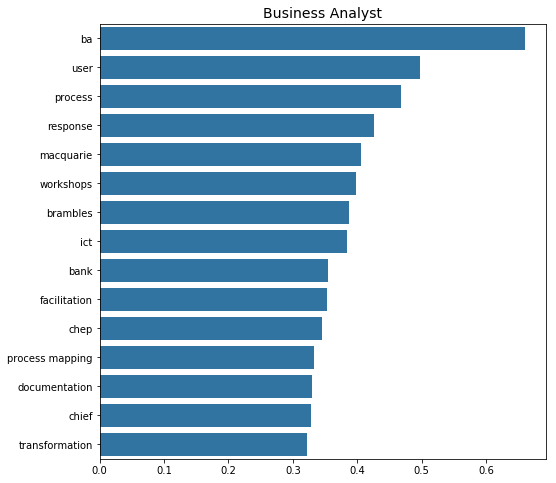

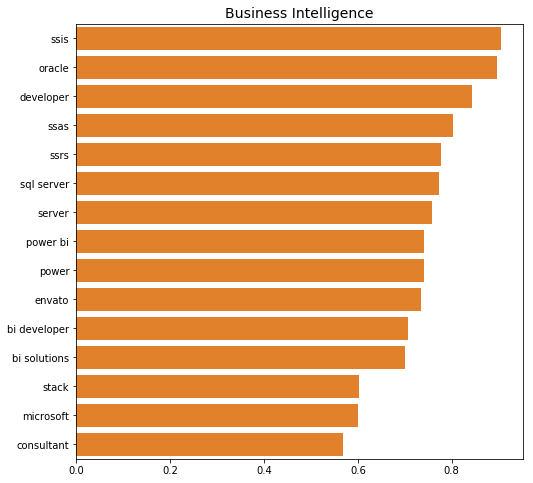

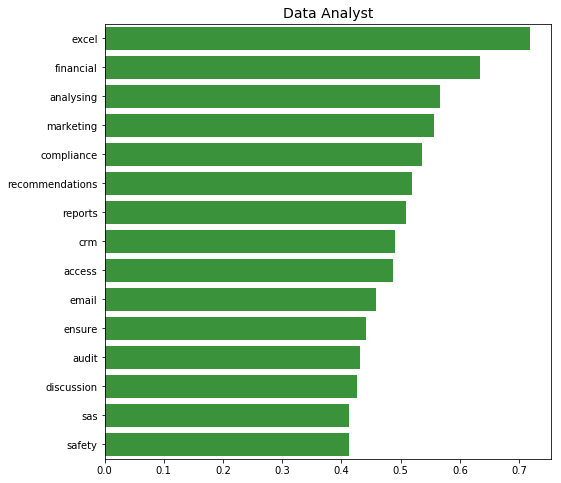

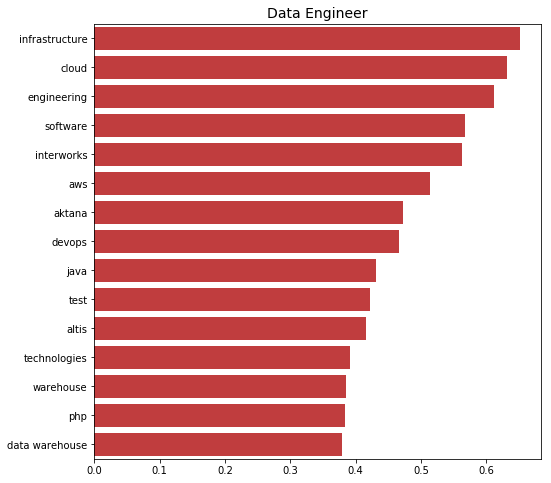

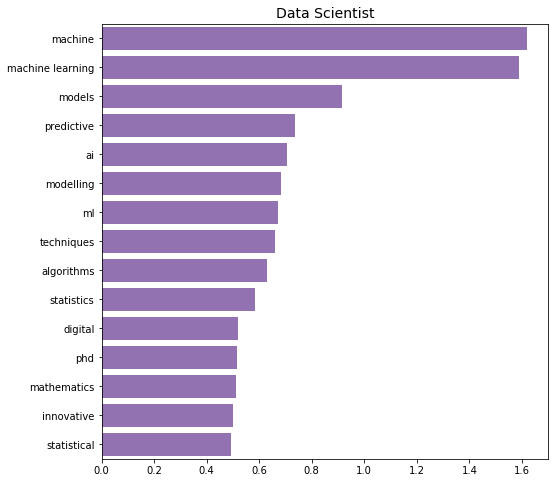

In [227]:
# plot top keywords per job title based on coefs
titles = ['Business Analyst', 'Business Intelligence','Data Analyst', 'Data Engineer', 'Data Scientist']
c=['C0', 'C1', 'C2', 'C3','C4']
for i in range(0,5):
        plt.figure(figsize = (8, 8)) 
        col = counts.columns[i]
        y = counts[col].sort_values(ascending=False).head(15).index
        x = counts[col].sort_values(ascending=False).head(15)
        sns.barplot(x=x, y=y, color=c[i])
        plt.title(titles[i], fontsize=14)
        plt.xlabel('')
        plt.show()


### Observations:


##### Top Factors Word Cloud


In [236]:
# add more stop words for word cloud
extra_words2 = ['data', 'team', 'Engineer', 'role', 'customer','machine','learning', 'client', 'Client', 'Customer']
stop_words2 = stop_words + extra_words2

In [237]:
def generate_wordcloud(text): 
    plt.figure(figsize = (13, 13), facecolor = None) 
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = stop_words2,
                          background_color='white'
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [238]:
data = dummied_data[['Description','title_fix']]

Business Analyst


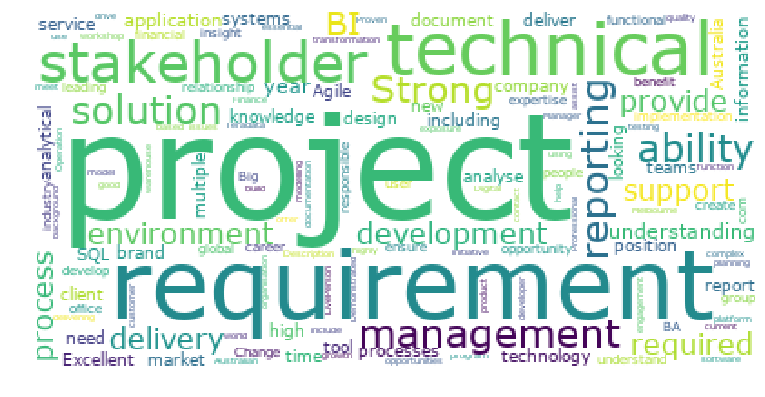

Business Intelligence


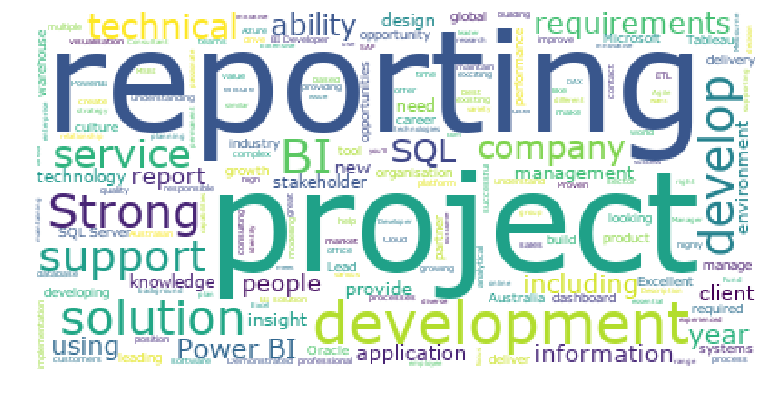

Data Analyst


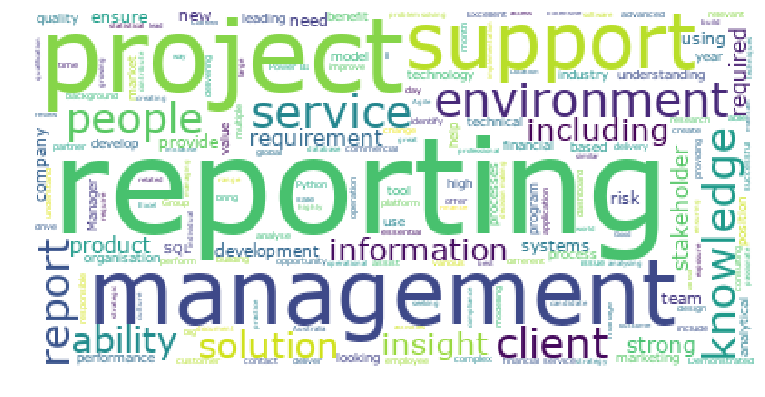

Data Engineer


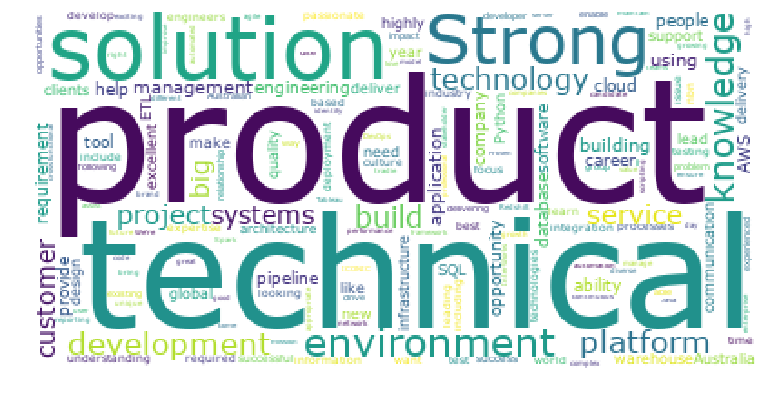

Data Scientist


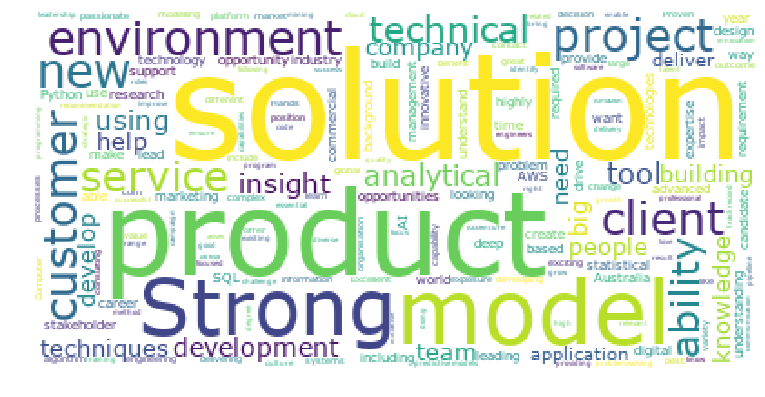

In [239]:
titles = ['Business Analyst', 'Business Intelligence','Data Analyst', 'Data Engineer', 'Data Scientist']
for i in range(0,5):
    text = ' '.join(desc for desc in data[data['title_fix']==titles[i]]['Description'])
    print(titles[i])
    generate_wordcloud(text)


### Observations:
'Customer' and 'Client' are predominant words through all the jobs (added these to stop words as they were crowding out other words)

'Machine Learning' is the predominant word among all Data Scientist jobs, with no real other stand out words. If I added machine learning to the stop words, I found that Data Scientist and Data Engineer were very similar to each other in regards to most common words,  other than that Data Scientists are also predominantly required to model where as Data Engineers are required to be technical more often.

Business Intelligence and Data Analyst roles are also quite similar in their predominant words of 'Project' and 'Reporting', however BI is more involved in development where as DA is more involved in management, presumably in regards to projects and reporting

Business Analysts are heavily involved in 'Project' and 'Requirement', presumably in getting the requirements of the project and are also required to have technical skills.






## Summary